In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Load the dataset
df = pd.read_csv('cleaned_train.csv')

In [ ]:
# Select features and target variable
X = df[['luxury_sales', 'fresh_sales', 'dry_sales', 'outlet_city']]
y = df['cluster_category']

In [ ]:
# Encode categorical target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Split data into training & testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# Gaussian noise to training data
noise_factor = 0.005
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)

In [ ]:
# Define Optimized Neural Network Model
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),  # Increased dropout

    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),  # Increased dropout

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.1),

    Dense(len(label_encoder.classes_), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


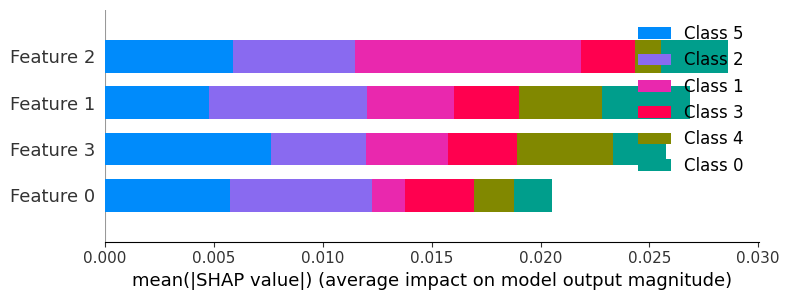

In [ ]:
import shap

# SHAP Explainer
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test[:100])

# Summary plot
shap.summary_plot(shap_values, X_test[:100])

In [ ]:
# Compile the model
optimizer = Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Callbacks: Early Stopping & Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get unique class labels
classes = np.unique(y_train)

# Compute class weights
computed_weights = compute_class_weight('balanced', classes=classes, y=y_train)

# Convert to dictionary format (match class labels)
class_weight_dict = {int(classes[i]): computed_weights[i] for i in range(len(classes))}

#Dynamically boost the weight for Class 5 (index 4 in zero-based, but matches the class label)
class_5_label = 5
class_weight_dict[class_5_label] = max(class_weight_dict[class_5_label], max(computed_weights) * 0.2)

print("Updated Class Weights:", class_weight_dict)

Updated Class Weights: {0: np.float64(0.6839180240237852), 1: np.float64(0.8312513255852039), 2: np.float64(2.6352602730398664), 3: np.float64(0.7478467119787062), 4: np.float64(3.2657448132561253), 5: np.float64(0.7622064999581506)}


In [ ]:
history = model.fit(X_train_noisy, y_train, epochs=30, batch_size=256, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler], class_weight=class_weight_dict)

Epoch 1/30
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - accuracy: 0.9158 - loss: 0.6016 - val_accuracy: 0.9684 - val_loss: 0.1921 - learning_rate: 3.0000e-04
Epoch 2/30
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.9674 - loss: 0.2578 - val_accuracy: 0.9780 - val_loss: 0.0933 - learning_rate: 3.0000e-04
Epoch 3/30
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.9770 - loss: 0.1551 - val_accuracy: 0.9919 - val_loss: 0.0475 - learning_rate: 3.0000e-04
Epoch 4/30
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.9894 - loss: 0.0802 - val_accuracy: 0.9977 - val_loss: 0.0329 - learning_rate: 3.0000e-04
Epoch 5/30
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.9944 - loss: 0.0506 - val_accuracy: 0.9989 - val_loss: 0.0263 - learning_rate: 3.0000e-04
Epoch 6/30
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.9957 - loss: 0.0428 - val_accuracy: 0.9993 - val_loss: 0.0231 - learning_rate: 3.0000e-04
Epoch 7/30
2419/2419 ━━━━━━━━━━━━━━━━━━━

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_train, y_train)
print(f"Train Loss: {loss:.4f}")
print(f"Train Accuracy: {accuracy:.4f}")

19352/19352 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.9998 - loss: 0.0121
Train Loss: 0.0123
Train Accuracy: 0.9998


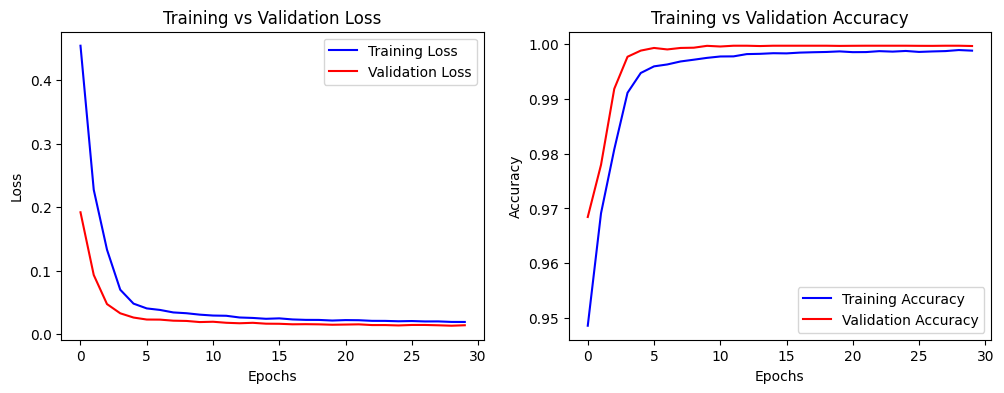

In [ ]:
# Plot Training & Validation Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Predict probabilities
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

4838/4838 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


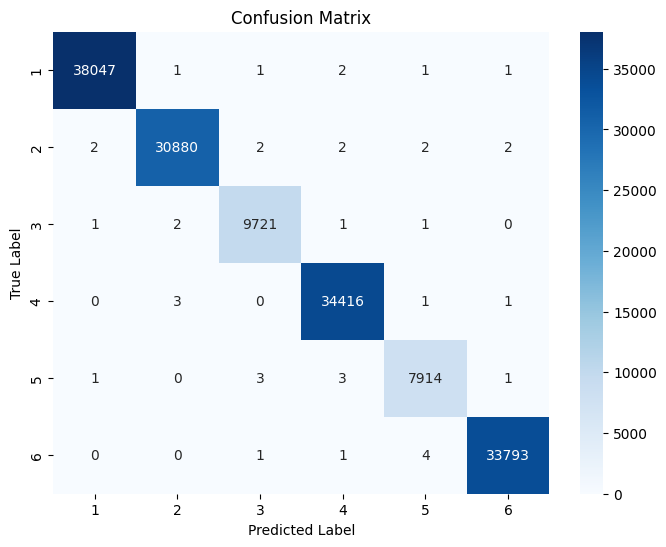

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[str(c) for c in label_encoder.classes_]))


Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     38053
           2       1.00      1.00      1.00     30890
           3       1.00      1.00      1.00      9726
           4       1.00      1.00      1.00     34421
           5       1.00      1.00      1.00      7922
           6       1.00      1.00      1.00     33799

    accuracy                           1.00    154811
   macro avg       1.00      1.00      1.00    154811
weighted avg       1.00      1.00      1.00    154811



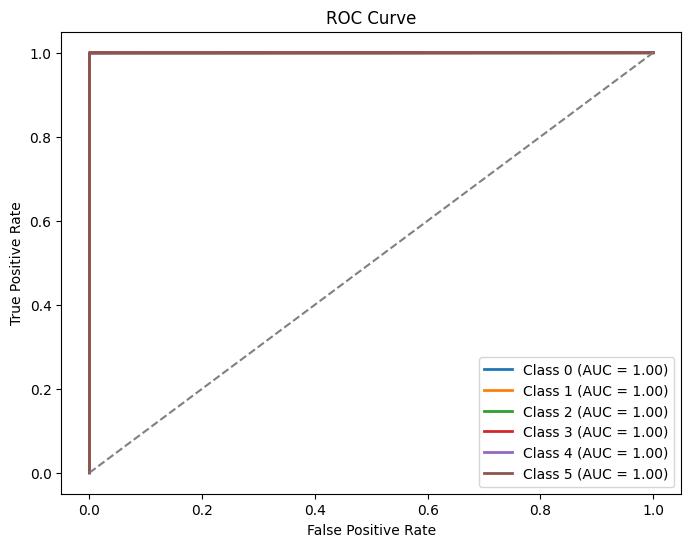

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming `y_test` and `y_pred_prob` are already available
n_classes = y_pred_prob.shape[1]

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_prob[:, i])  # Simplified
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Add diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Labels and display
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
import pickle

In [ ]:
# Save the model
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
import tensorflow as tf
from tensorflow import keras

model.save("model.h5")
model = keras.models.load_model("model.h5")

In [ ]:
# Load cleaned test dataset
cleaned_test = pd.read_csv('cleaned_test.csv')

In [ ]:
# Select the same features used in training
X_cleaned_test = cleaned_test[['luxury_sales', 'fresh_sales', 'dry_sales', 'outlet_city']]

In [ ]:
# Predict cluster categories
cleaned_test_predictions = model.predict(X_cleaned_test)
cleaned_test_predictions = np.argmax(cleaned_test_predictions, axis=1)

1274/1274 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [ ]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

4838/4838 - 10s - 2ms/step - accuracy: 0.9997 - loss: 0.0134
Test Accuracy: 0.9997
Test Loss: 0.0134


In [ ]:
# Save predictions
cleaned_test.to_csv('cleaned_test_predictions.csv', index=False)

print("Predictions saved successfully!")

Predictions saved successfully!
